In [1]:
# Loading the neccesary packages
import numpy as np
import pandas as pd
import pymc3 as pm 
import matplotlib.pyplot as plt
import matplotlib as plt_base
plt_base.rcParams.update({'errorbar.capsize': 3}) # Seting caps on error bars
import theano
import theano.tensor as tt
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing as mp
import re
import os
import sys
from tqdm import tqdm

C:\Users\Vojtech\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Utilities
def sample_mixture(sample_M1, sample_M2, M1_to_M2_ratio):
    """Function sampel from the mixture under models M1 and M2 according to the provided ratio.
    
    Where:
    sample_M1 - sample from the distribution under M1
    sample_M2 - sample from the distribution under M2
    M1_to_M2_ratio - Ration of the samples for M1 in favor of M2
    """           

    i = 0
    j = 0
    mixture_sample = np.random.randn(sample_M1.shape[0])[:,None]
    while (i < len(sample_M1.T)) and (j < len(sample_M2.T)):
        u = np.random.uniform()
        if u < (M1_to_M2_ratio / (M1_to_M2_ratio + 1)):
            sample_new = sample_M1[:,i]  
            mixture_sample = np.concatenate((mixture_sample, sample_new[:,None]), axis = 1)
            i += 1
        else:
            sample_new = sample_M2[:,j] 
            mixture_sample = np.concatenate((mixture_sample, sample_new[:,None]), axis = 1)
            j+=1
    return mixture_sample[:,1:]


def mse(Y_truth, Y_new):
    """Function calculates the mean squared error for the posterior samples Y_new"""
    Y_new_mean = np.mean(Y_new, axis = 1)[:,None]
    mse_calc = np.mean((Y_new_mean - Y_truth[:,None]) ** 2)
    return mse_calc

def posterior_predictions(pymc3_model, gp, posterior_trace, x_new, theta_dim, file, sn_start = 0, batch_n = 0,
                          batch_size = 500, n_core = 1, noise = True):
    """Samples from posterior predictive distribution.
    
    Generates samples from posterior predictive distribution for given input x_new and
    posterior samples of calibration parameters.
    
    Args:
      pymc3_model: A pymc3_model obejct defining the model for prediciton
      gp: A pymc3.gp.marginal object representing the GP model for observables
      posterior_samples: A pymc3 trace with posterir samples of calibration parameters
      x_new: Values of inputs for prediction
      theta_dim: A dimension of the calibration parameters
      n_core: Number of cores to be used for the computation
      noise: Should predictive noise be included?
      
    Return:
      A numpy array with samples from predictive distribution
      
    """
    
    # Batching
    sn_start = sn_start
    sn_end = np.minimum(sn_start + batch_size, len(posterior_trace))
    batch = batch_n
    # Exception catching
    
    while (sn_start < sn_end):
        try:
            #Unix shell comands for smooth parallel computing with theano
            #os.system('rm -rf ~/theano/')
            #os.system('rm -rf /tmp/kejzlarv/theano.NOBACKUP')
            #os.system('theano-cache clear')
            batch += 1
            print("Batch start index: " + str(sn_start))
            prediction_samples = np.empty((len(x_new), 0))
            posterior_samples = posterior_trace[sn_start:sn_end]

            # Batch sampling
            if n_core == 1:
                for sample_point in tqdm(posterior_samples, desc = "Sampling predictive distribution"):
                    y_new = sample_prediction(sample_point, x_new, theta_dim, noise)
                    if len(x_new) == 1: # Prediction for one vale handling
                        prediction_samples = np.append(prediction_samples, y_new)
                    else:
                        prediction_samples = np.concatenate((prediction_samples, y_new), axis = 1)
            elif n_core > 1:
                prediction_samples = Parallel(n_jobs = n_core)(delayed(sample_prediction)(sample_point, x_new, theta_dim, noise)
                                                              for sample_point in posterior_samples)
                # Needs to be reshaped
                prediction_samples = np.array(prediction_samples)
                prediction_samples = prediction_samples.reshape(prediction_samples.shape[0:2]).T

            sn_start = sn_end
            sn_end = np.minimum(sn_start + batch_size, len(posterior_trace))
            # Unix
            #np.save(file + "/batch_" + str(batch) + "s_end_" + str(sn_start), prediction_samples)
            # Windows
            np.save(file + "\\batch_" + str(batch) + "_s_end_" + str(sn_start), prediction_samples)
        except Exception:
            print("Exception raised and the batch was skipped")
            sn_start = sn_end
            sn_end = np.minimum(sn_start + batch_size, len(posterior_trace))
         
    return prediction_samples

def sample_prediction(sample_point, x_new, theta_dim, noise = True):
    """Generate single sample from posterior predictive distribution.
    """
    
    # Sample point for theta
    theta_sample_point = sample_point["theta"]
            
    # Exception handling for ValueError
    try:
        with gp_toy_model:
            input_new = np.concatenate([x_new, np.tile(theta_sample_point, (len(x_new), 1))], axis = 1)
            mu, cov = gp_model.predict(input_new, point = sample_point, pred_noise = noise)
            if input_new.shape[0] == 1: # Prediction for one value handling
                prediction_sample_point = pm.MvNormal.dist(mu = mu, cov = cov).random(1)
            else:
                prediction_sample_point = pm.MvNormal.dist(mu = mu, cov = cov).random(1)[:, None]
    except ValueError:
        print("Exception in inner loop")
        return
    return prediction_sample_point

def batch_to_ndarray(file):
    """Combine batches of samples from posterior predictive distribution into a single numpy.ndarray.
    
    Args:
      file: A string with the path to the folder with batches.
      
    Returns:
      A pandas DataFrame that is concatenation of all the batches in "file"
    """
    file_batch = os.listdir(file)
    file_batch.sort(key=lambda x: int(re.findall('\d+', x)[0]))
    posterior_sample = np.load(file + "\\" + file_batch[0])
    for batch in file_batch[1:]:
        #print(batch)
        new_batch = np.load(file + "\\" + batch)
        if new_batch.ndim > 1:
            posterior_sample = np.concatenate((posterior_sample, new_batch),
                                          axis = posterior_sample.ndim - 1)
    posterior_sample = pd.DataFrame(posterior_sample).dropna(axis=1)
    return posterior_sample

In [3]:
#######################################################################################################
####### This code reproduces Table 4 in "Bayesian averaging of computer models with domain
####### discrepancies:  towards a nuclear physics perspective" from already precomputed results
# Results trianing dataset
np.random.seed(0)
# Training dataset
b_energy = np.array([-1591.66564, -1575.83264, -1559.48264, -1391.21286, -1362.59073,
                     -1418.40602, -1431.26039, -1377.76048, -1277.70063, -1308.99194])
c_radii = np.array([5.50638, 5.46952, 5.43971, 5.41899, 5.40357, 5.39422, 4.60966, 4.598, 4.52748, 4.49294])

Z_N_energy = np.array([[82, 120], [82, 118], [82, 116], [68, 104], [66, 102],
                       [72, 104], [70, 108], [70, 100], [66, 90], [64, 96]])
Z_N_radii = np.array([[82, 132], [82, 128], [82, 124], [82, 120], [82, 118],
                          [82, 116], [50, 74], [50, 72], [50, 62], [50, 58]])
Z_N = np.concatenate([Z_N_energy, Z_N_radii], axis = 0)
data = np.concatenate([b_energy, c_radii])

# Loading precomputed results
prediction_sample_1 = np.load("pred_600_train.npy")
prediction_sample_2 = np.load("pred_-50_train.npy")
m1_e = np.load("evidence_600_train.npy")
m2_e = np.load("evidence_-50_train.npy")

# Burn first 5000 samples
cutoff = 5000
prediction_sample_1_burn = np.array(prediction_sample_1)[:,cutoff:]
prediction_sample_2_burn = np.array(prediction_sample_2)[:,cutoff:]
# Sample BME posterio mean predictor
posterior_BMA = sample_mixture(prediction_sample_1_burn, prediction_sample_2_burn, m1_e[-1] / m2_e[-1])

print("Posterior M1: " + str(np.round(m1_e[-1]/(m1_e[-1] + m2_e[-1]), decimals=2)))
print("Posterior M2: " + str(np.round(m2_e[-1]/(m1_e[-1] + m2_e[-1]), decimals=2)))

# Results for binding energies - training dataset
mse_1 = mse(data[:10], prediction_sample_1_burn[:10,:])
mse_2 = mse(data[:10], prediction_sample_2_burn[:10,:])
mse_bma = mse(data[:10], posterior_BMA[:10,:])
print("##### Binding energies results:")
print("root PMSE(M1) = " + str(np.round(np.sqrt(mse_1), decimals=3)))
print("root PMSE(M2) = " + str(np.round(np.sqrt(mse_2), decimals=3)))
print("root PMSE(BMA) = " + str(np.round(np.sqrt(mse_bma), decimals=3)))
print("r^2 M1: " + str(np.round(1 - mse_bma / mse_1, decimals= 3)))
print("r^2 M2: " + str(np.round(1 - mse_bma / mse_2, decimals= 3)))

# Results for charge radii - training dataset
print("##### Charge radii results:")
mse_1 = mse(data[10:], prediction_sample_1_burn[10:,:])
mse_2 = mse(data[10:], prediction_sample_2_burn[10:,:])
mse_bma = mse(data[10:], posterior_BMA[10:,:])
print("root PMSE(M1) = " + str(np.round(np.sqrt(mse_1), decimals=3)))
print("root PMSE(M2) = " + str(np.round(np.sqrt(mse_2), decimals=3)))
print("root PMSE(BMA) = " + str(np.round(np.sqrt(mse_bma), decimals=3)))
print("r^2 M1: " + str(np.round(1 - mse_bma / mse_1, decimals= 3)))
print("r^2 M2: " + str(np.round(1 - mse_bma / mse_2, decimals= 3)))

Posterior M1: 0.18
Posterior M2: 0.82
##### Binding energies results:
root PMSE(M1) = 0.034
root PMSE(M2) = 0.032
root PMSE(BMA) = 0.025
r^2 M1: 0.455
r^2 M2: 0.394
##### Charge radii results:
root PMSE(M1) = 0.013
root PMSE(M2) = 0.013
root PMSE(BMA) = 0.011
r^2 M1: 0.255
r^2 M2: 0.223


In [40]:
#######################################################################################################
####### This code reproduces Table 5 in "Bayesian averaging of computer models with domain
####### discrepancies:  towards a nuclear physics perspective" from already precomputed results
# Results testing dataset
np.random.seed(0)
# Testing dataset
b_energy = np.array([-1606.98364, -1621.80264, -1266.32864, -1281.30023, -1295.59749,
                     -1321.4733, -1293.72542, -1323.78552, -1350.4741, -1337.71449])
c_radii = np.array([5.48896, 5.45007, 5.42834, 4.5422, 4.55895])

Z_N_energy = np.array([[82, 122], [82, 124], [64, 90], [64, 92], [64, 94],
                       [64, 98], [66, 92], [66, 96], [66, 100], [66, 98]])
Z_N_radii = np.array([[82, 130], [82, 126], [82, 122], [50, 64], [50, 66]])
Z_N_test = np.concatenate([Z_N_energy, Z_N_radii], axis = 0)
data_test = np.concatenate([b_energy, c_radii])

# Loading precomputed results
prediction_sample_1 = np.load("pred_600_test.npy")
prediction_sample_2 = np.load("pred_-50_test.npy")
m1_e = np.load("evidence_600_train.npy")
m2_e = np.load("evidence_-50_train.npy")

# Burn first 5000 samples
cutoff = 40000
prediction_sample_1_burn = np.array(prediction_sample_1)[:,cutoff:]
prediction_sample_2_burn = np.array(prediction_sample_2)[:,cutoff:]
# Sample BME posterio mean predictor
posterior_BMA = sample_mixture(prediction_sample_1_burn, prediction_sample_2_burn, m1_e[-1] / m2_e[-1])
# Results for binding energies - training dataset
mse_1 = mse(data_test[:10], prediction_sample_1_burn[:10,:])
mse_2 = mse(data_test[:10], prediction_sample_2_burn[:10,:])
mse_bma = mse(data_test[:10], posterior_BMA[:10])
print("##### Binding energies results:")
print("root PMSE(M1) = " + str(np.round(np.sqrt(mse_1), decimals=3)))
print("root PMSE(M2) = " + str(np.round(np.sqrt(mse_2), decimals=3)))
print("root PMSE(BMA) = " + str(np.round(np.sqrt(mse_bma), decimals=3)))
print("r^2 M1: " + str(np.round(1 - mse_bma / mse_1, decimals= 3)))
print("r^2 M2: " + str(np.round(1 - mse_bma / mse_2, decimals= 3)))

# Results for charge radii - training dataset
print("##### Charge radii results:")
mse_1 = mse(data_test[10:], prediction_sample_1_burn[10:,:])
mse_2 = mse(data_test[10:], prediction_sample_2_burn[10:,:])
mse_bma = mse(data_test[10:], posterior_BMA[10:,:])
print("root PMSE(M1) = " + str(np.round(np.sqrt(mse_1), decimals=3)))
print("root PMSE(M2) = " + str(np.round(np.sqrt(mse_2), decimals=3)))
print("root PMSE(BMA) = " + str(np.round(np.sqrt(mse_bma), decimals=3)))
print("r^2 M1: " + str(np.round(1 - mse_bma / mse_1, decimals= 3)))
print("r^2 M2: " + str(np.round(1 - mse_bma / mse_2, decimals= 3)))

##### Binding energies results:
root PMSE(M1) = 0.434
root PMSE(M2) = 0.563
root PMSE(BMA) = 0.4
r^2 M1: 0.147
r^2 M2: 0.494
##### Charge radii results:
root PMSE(M1) = 0.024
root PMSE(M2) = 0.009
root PMSE(BMA) = 0.008
r^2 M1: 0.879
r^2 M2: 0.118


In [183]:
#####################################################################################
# Averaging nuclear (mass) models computation code
np.random.seed(0)
# Training dataset
b_energy = np.array([-1591.66564, -1575.83264, -1559.48264, -1391.21286, -1362.59073,
                     -1418.40602, -1431.26039, -1377.76048, -1277.70063, -1308.99194])
c_radii = np.array([5.50638, 5.46952, 5.43971, 5.41899, 5.40357, 5.39422, 4.60966, 4.598, 4.52748, 4.49294])

Z_N_energy = np.array([[82, 120], [82, 118], [82, 116], [68, 104], [66, 102],
                       [72, 104], [70, 108], [70, 100], [66, 90], [64, 96]])
Z_N_radii = np.array([[82, 132], [82, 128], [82, 124], [82, 120], [82, 118],
                          [82, 116], [50, 74], [50, 72], [50, 62], [50, 58]])
Z_N = np.concatenate([Z_N_energy, Z_N_radii], axis = 0)
data = np.concatenate([b_energy, c_radii])

a = 600 # 600 for M1, 50 for M2
m_i = 1 # 1 for M1, -1 for M2
name = str(a * m_i) + "_train"

mean_trans = ((Z_N[:,0] + Z_N[:,1]) / (1 + m_i * (Z_N[:,0] + Z_N[:,1]) / a ))[:,None]
resi_class = np.array([1]*10 + [2]*10)[:,None]
X_input = np.concatenate([resi_class, Z_N, mean_trans], axis = 1)

l_scale_shape = 3

def cov_scale_noise_function(x, sigma1, sigma2):
    sigma = tt.switch(tt.eq(x,1), sigma1, sigma2)
    return sigma

X_input_shared = theano.shared(X_input)

with pm.Model() as gp_toy_dif_obs:
    theta1 = pm.Normal("theta1", mu = 0, sd = 3)
    theta2 = pm.Normal("theta2", mu = 0, sd = 3)
    theta_tilda_r = pm.Normal("theta_tilda_r", mu = 0, sd = 1)
    
    sigma_2 = pm.InverseGamma("sigma_2", alpha=3, beta=1)
    
    l_scale = pm.Gamma("l_scale", alpha=60, beta=2, shape = l_scale_shape)
    sigma_1 = pm.InverseGamma("sigma_1", alpha=3, beta=1)
    eta_1 = pm.InverseGamma("eta_1", alpha = 1, beta=500)
    eta_2 = pm.InverseGamma("eta_2", alpha = 1, beta=500)
        
    
    # Stacking theta
    thetas = tt.concatenate([tt.tile(theta1, (10, 1)), tt.tile(theta2, (10, 1))], axis=0)
    X_input_theta = tt.concatenate([X_input_shared, thetas], axis = 1)
    
    # Mean function
    coeffs = tt.stack([0, 0, 0, theta_tilda_r, 1])
    mean = pm.gp.mean.Linear(coeffs=coeffs)
        
    # Noise cov
    cov_noise_base = pm.gp.cov.WhiteNoise(1)
    cov_noise = pm.gp.cov.ScaledCov(X_input.shape[1] + 1, scaling_func=cov_scale_noise_function,
                                    args=(sigma_1, sigma_2), cov_func= cov_noise_base, active_dims = [0])
    

    # Scaling covariance
    cov_base_scale = pm.gp.cov.Constant(1)
    cov_scale = pm.gp.cov.ScaledCov(X_input.shape[1] + 1, scaling_func=cov_scale_noise_function,
                                        args=(eta_1, eta_2), cov_func= cov_base_scale, active_dims = [0])
    cov_model = pm.gp.cov.ExpQuad(X_input.shape[1] + 1, ls=l_scale, active_dims=[1,2,4])
    cov = cov_model * cov_scale
        
    gp_model = pm.gp.Marginal(mean_func= mean, cov_func = cov)
    y_gp = gp_model.marginal_likelihood("y", X = X_input_theta, y = data, noise = cov_noise)

In [181]:
n_tune = 10000
n_sample = 140000
n_mc = 800000

# Calibration
with gp_toy_dif_obs:
    trace = pm.sample(n_sample, tune = n_tune, chains=1)
pm.backends.ndarray.save_trace(trace, directory = name)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


KeyboardInterrupt: 

In [184]:
# Evidence integral computaiton
np.random.seed(0)
with pm.Model() as priors_model:
    
    theta1 = pm.Normal("theta1", mu = 0, sd = 3)
    theta2 = pm.Normal("theta2", mu = 0, sd = 3)
    theta_tilda_r = pm.Normal("theta_tilda_r", mu = 0, sd = 1)
    
    sigma_2 = pm.InverseGamma("sigma_2", alpha=3, beta=1)
    
    l_scale = pm.Gamma("l_scale", alpha=60, beta=2, shape = l_scale_shape)
    sigma_1 = pm.InverseGamma("sigma_1", alpha=3, beta=1)
    eta_1 = pm.InverseGamma("eta_1", alpha = 1, beta=500)
    eta_2 = pm.InverseGamma("eta_2", alpha = 1, beta=500)
    
    trace_priors = pm.sample(n_mc, tune = 10000, chains = 1)


log_likelihood = np.empty(0)
mc_integral = np.empty(n_mc)
logp = y_gp.logp

for i in tqdm(range(n_mc), desc = "Log likelihood eval"):
    log_likelihood = np.append(log_likelihood, logp(trace_priors[i], transform = None))

for i in tqdm(range(n_mc), desc = "Integral calc"):
    m = max(log_likelihood[:(i + 1)])
    mc_integral[i] = (np.exp(m) * np.sum(np.exp(log_likelihood[:(i + 1)] - m))) / (i + 1)
                
np.save("evidence_" + name, mc_integral)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eta_2, eta_1, sigma_1, l_scale, sigma_2, theta_tilda_r, theta2, theta1]
100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [00:33<00:00, 891.21it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Integral calc: 100%|████████████████████████████████████████████████████████████| 20000/20000 [00:22<00:00, 906.55it/s]


In [ ]:
# Sampling predictive distribution for training dataset
os.mkdir(os.getcwd() + "/pred_" + name)
post = posterior_predictions(gp_toy_dif_obs, gp_model, trace, X_input , 1, os.getcwd() + "/pred_" + name, n_core = 1, noise = False)
prediction_sample = batch_to_ndarray(os.getcwd() + "/pred_" + name)
np.save("pred_" + name + ".npy", prediction_sample)

In [ ]:
# Sampling predictive distribution for testing dataset
np.random.seed(0)
name = str(a * m_i) + "_test"

b_energy = np.array([-1606.98364, -1621.80264, -1266.32864, -1281.30023, -1295.59749,
                     -1321.4733, -1293.72542, -1323.78552, -1350.4741, -1337.71449])
c_radii = np.array([5.48896, 5.45007, 5.42834, 4.5422, 4.55895])

Z_N_energy = np.array([[82, 122], [82, 124], [64, 90], [64, 92], [64, 94],
                       [64, 98], [66, 92], [66, 96], [66, 100], [66, 98]])
Z_N_radii = np.array([[82, 130], [82, 126], [82, 122], [50, 64], [50, 66]])
Z_N_test = np.concatenate([Z_N_energy, Z_N_radii], axis = 0)
data_test = np.concatenate([b_energy, c_radii])

mean_trans = ((Z_N_test[:,0] + Z_N_test[:,1]) / (1 + m_i * (Z_N_test[:,0] + Z_N_test[:,1]) / a ))[:,None]
resi_class = np.array([1]*10 + [2]*5)[:,None]
X_input = np.concatenate([resi_class, Z_N, mean_trans], axis = 1)

os.mkdir(os.getcwd() + "/pred_" + name)
post = posterior_predictions(gp_toy_dif_obs, gp_model, trace, X_input , 1, os.getcwd() + "/pred_" + name, n_core = 1, noise = False)
prediction_sample = batch_to_ndarray(os.getcwd() + "/pred_" + name)
np.save("pred_" + name + ".npy", prediction_sample)

In [5]:
# Posterior mean predictor results - Training dataset
# Loading precomputed results
np.random.seed(0)
prediction_sample_1 = np.load("pred_600_train.npy")
prediction_sample_2 = np.load("pred_-50_train.npy")
m1_e = np.load("evidence_600_train.npy")
m2_e = np.load("evidence_-50_train.npy")

# Burn first 5000 samples
cutoff = 5000
prediction_sample_1_burn = np.array(prediction_sample_1)[:,cutoff:]
prediction_sample_2_burn = np.array(prediction_sample_2)[:,cutoff:]
# Sample BME posterio mean predictor
posterior_BMA = sample_mixture(prediction_sample_1_burn, prediction_sample_2_burn, m1_e[-1] / m2_e[-1])

print("Posterior M1: " + str(np.round(m1_e[-1]/(m1_e[-1] + m2_e[-1]), decimals=2)))
print("Posterior M2: " + str(np.round(m2_e[-1]/(m1_e[-1] + m2_e[-1]), decimals=2)))

# Results for binding energies - training dataset
mse_1 = mse(data[:10], prediction_sample_1_burn[:10,:])
mse_2 = mse(data[:10], prediction_sample_2_burn[:10,:])
mse_bma = mse(data[:10], posterior_BMA[:10,:])
print("##### Binding energies results:")
print("root PMSE(M1) = " + str(np.round(np.sqrt(mse_1), decimals=3)))
print("root PMSE(M2) = " + str(np.round(np.sqrt(mse_2), decimals=3)))
print("root PMSE(BMA) = " + str(np.round(np.sqrt(mse_bma), decimals=3)))
print("r^2 M1: " + str(np.round(1 - mse_bma / mse_1, decimals= 3)))
print("r^2 M2: " + str(np.round(1 - mse_bma / mse_2, decimals= 3)))

# Results for charge radii - training dataset
print("##### Charge radii results:")
mse_1 = mse(data[10:], prediction_sample_1_burn[10:,:])
mse_2 = mse(data[10:], prediction_sample_2_burn[10:,:])
mse_bma = mse(data[10:], posterior_BMA[10:,:])
print("root PMSE(M1) = " + str(np.round(np.sqrt(mse_1), decimals=3)))
print("root PMSE(M2) = " + str(np.round(np.sqrt(mse_2), decimals=3)))
print("root PMSE(BMA) = " + str(np.round(np.sqrt(mse_bma), decimals=3)))
print("r^2 M1: " + str(np.round(1 - mse_bma / mse_1, decimals= 3)))
print("r^2 M2: " + str(np.round(1 - mse_bma / mse_2, decimals= 3)))

Posterior M1: 0.18
Posterior M2: 0.82
##### Binding energies results:
root PMSE(M1) = 0.034
root PMSE(M2) = 0.032
root PMSE(BMA) = 0.025
r^2 M1: 0.455
r^2 M2: 0.394
##### Charge radii results:
root PMSE(M1) = 0.013
root PMSE(M2) = 0.013
root PMSE(BMA) = 0.011
r^2 M1: 0.255
r^2 M2: 0.223


In [6]:
# Figures from appendix - Training dataset
m1 = prediction_sample_1_burn.mean(axis= 1)
m2 = prediction_sample_2_burn.mean(axis= 1)
mbma = posterior_BMA.mean(axis= 1)

m1err = pm.stats.quantiles(prediction_sample_1_burn.transpose(),qlist = (5,95))
m2err = pm.stats.quantiles(prediction_sample_2_burn.transpose(),qlist = (5,95))
mbmaerr = pm.stats.quantiles(posterior_BMA.transpose(),qlist = (5,95))
m1err = [m1err[5], m1err[95]]
m2err = [m2err[5], m2err[95]]
mbmaerr = [mbmaerr[5], mbmaerr[95]]

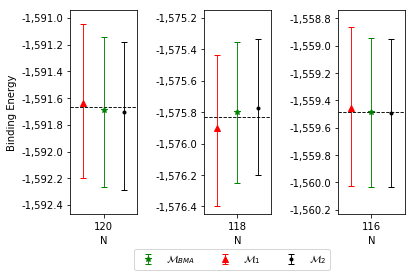

In [7]:
# Fig 3 a)
nuclei = [ 0, 1, 2]
fig_n = 1
f = plt.figure(figsize=(6,3.75))

for i in nuclei:
    fi = plt.subplot(130 + fig_n)
    fi.get_yaxis().set_major_formatter(plt_base.ticker.FuncFormatter(lambda x, p: format(round(float(x),2), ',')))
    x = Z_N[[i],1]
    thickness_c = 1
    thickness_l = 0.9
    f1 = plt.errorbar(x, mbma[[i]], yerr=np.abs(np.array(mbmaerr)[:,[i]] - mbma[[i]]), fmt='*g', ecolor='g', capthick=thickness_c, elinewidth=thickness_l)
    f2 = plt.errorbar(x + 0.3, m1[[i]], yerr=np.abs(np.array(m1err)[:,[i]] - m1[[i]]), fmt='^r', ecolor='r', capthick=thickness_c, elinewidth=thickness_l)
    f3 = plt.errorbar(x - 0.3, m2[[i]], yerr=np.abs(np.array(m2err)[:,[i]] - m2[[i]]), fmt='.k', ecolor='black', capthick=thickness_c, elinewidth=thickness_l)
    plt.xlabel("N")
    if fig_n == 1:
        plt.ylabel('Binding Energy')
    plt.ylim(np.array(mbmaerr)[:,[i]][0] - 0.2,np.array(mbmaerr)[:,[i]][1] + 0.2)
    plt.plot([x + 0.5, x - 0.5], [data[[i]],data[[i]]], 'k-', linestyle = "--", color = "black", linewidth = thickness_l)
    plt.xlim((x + 0.5, x - 0.5))
    plt.xticks(x, x)
    fig_n = fig_n + 1 
plt.subplots_adjust(wspace = 1)
plt.legend((f1,f2,f3),(r'$\mathcal{M}_{BMA}$', r'$\mathcal{M}_{1}$', r'$\mathcal{M}_{2}$'),loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
            bbox_transform = plt.gcf().transFigure, ncol=3)
f.savefig('BE_train.pdf', bbox_inches='tight',dpi = 300)

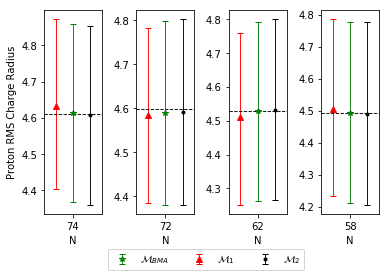

In [8]:
# Fig 3 b)
nuclei = [16, 17, 18, 19]
fig_n = 1
f = plt.figure(figsize=(6,3.75))
for i in nuclei:
    plt.subplot(140 + fig_n)
    x = Z_N[[i],1]
    thickness_c = 1
    thickness_l = 0.9
    f1 = plt.errorbar(x, mbma[[i]], yerr=np.abs(np.array(mbmaerr)[:,[i]] - mbma[[i]]), fmt='*g', ecolor='g', capthick=thickness_c, elinewidth=thickness_l)
    f2 = plt.errorbar(x + 0.3, m1[[i]], yerr=np.abs(np.array(m1err)[:,[i]] - m1[[i]]), fmt='^r', ecolor='r', capthick=thickness_c, elinewidth=thickness_l)
    f3 = plt.errorbar(x - 0.3, m2[[i]], yerr=np.abs(np.array(m2err)[:,[i]] - m2[[i]]), fmt='.k', ecolor='black', capthick=thickness_c, elinewidth=thickness_l)
    plt.xlabel("N")
    if fig_n == 1:
        plt.ylabel('Proton RMS Charge Radius')
    plt.plot([x + 0.5, x - 0.5], [data[[i]],data[[i]]], 'k-', linestyle = "--", color = "black", linewidth = thickness_l)
    plt.xlim((x + 0.5, x - 0.5))
    plt.xticks(x, x)
    fig_n = fig_n + 1
    
plt.subplots_adjust(wspace = 0.6)
plt.legend((f1,f2,f3),(r'$\mathcal{M}_{BMA}$', r'$\mathcal{M}_{1}$', r'$\mathcal{M}_{2}$'),loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
            bbox_transform = plt.gcf().transFigure, ncol=3)
f.savefig('RMS_train.pdf', bbox_inches='tight',dpi = 300)

In [9]:
# Posterior mean predictor results - Testing dataset
np.random.seed(0)
# Training dataset
b_energy = np.array([-1606.98364, -1621.80264, -1266.32864, -1281.30023, -1295.59749,
                     -1321.4733, -1293.72542, -1323.78552, -1350.4741, -1378.69547, -1337.71449])
c_radii = np.array([5.48896, 5.45007, 5.42834, 4.5422, 4.55895])

Z_N_energy = np.array([[82, 122], [82, 124], [64, 90], [64, 92], [64, 94],
                       [64, 98], [66, 92], [66, 96], [66, 100], [66, 102], [66, 98]])
Z_N_radii = np.array([[82, 130], [82, 126], [82, 122], [50, 64], [50, 66]])
Z_N_test = np.concatenate([Z_N_energy, Z_N_radii], axis = 0)
data_test = np.concatenate([b_energy, c_radii])

# Loading precomputed results
prediction_sample_1 = np.load("pred_600_test.npy")
prediction_sample_2 = np.load("pred_-50_test.npy")
m1_e = np.load("evidence_600_train.npy")
m2_e = np.load("evidence_-50_train.npy")

# Burn first 5000 samples
cutoff = 40000
prediction_sample_1_burn = np.array(prediction_sample_1)[:,cutoff:]
prediction_sample_2_burn = np.array(prediction_sample_2)[:,cutoff:]
# Sample BME posterio mean predictor
posterior_BMA = sample_mixture(prediction_sample_1_burn, prediction_sample_2_burn, m1_e[-1] / m2_e[-1])
# Results for binding energies - training dataset
mse_1 = mse(data_test[:11], prediction_sample_1_burn[:11,:])
mse_2 = mse(data_test[:11], prediction_sample_2_burn[:11,:])
mse_bma = mse(data_test[:11], posterior_BMA[:11])
print("##### Binding energies results:")
print("root PMSE(M1) = " + str(np.round(np.sqrt(mse_1), decimals=3)))
print("root PMSE(M2) = " + str(np.round(np.sqrt(mse_2), decimals=3)))
print("root PMSE(BMA) = " + str(np.round(np.sqrt(mse_bma), decimals=3)))
print("r^2 M1: " + str(np.round(1 - mse_bma / mse_1, decimals= 3)))
print("r^2 M2: " + str(np.round(1 - mse_bma / mse_2, decimals= 3)))

# Results for charge radii - training dataset
print("##### Charge radii results:")
mse_1 = mse(data_test[11:], prediction_sample_1_burn[11:,:])
mse_2 = mse(data_test[11:], prediction_sample_2_burn[11:,:])
mse_bma = mse(data_test[11:], posterior_BMA[11:,:])
print("root PMSE(M1) = " + str(np.round(np.sqrt(mse_1), decimals=3)))
print("root PMSE(M2) = " + str(np.round(np.sqrt(mse_2), decimals=3)))
print("root PMSE(BMA) = " + str(np.round(np.sqrt(mse_bma), decimals=3)))
print("r^2 M1: " + str(np.round(1 - mse_bma / mse_1, decimals= 3)))
print("r^2 M2: " + str(np.round(1 - mse_bma / mse_2, decimals= 3)))

##### Binding energies results:
root PMSE(M1) = 0.414
root PMSE(M2) = 0.539
root PMSE(BMA) = 0.384
r^2 M1: 0.142
r^2 M2: 0.494
##### Charge radii results:
root PMSE(M1) = 0.024
root PMSE(M2) = 0.009
root PMSE(BMA) = 0.008
r^2 M1: 0.879
r^2 M2: 0.118


In [10]:
# Figures from appendix - Testing dataset
m1 = prediction_sample_1_burn.mean(axis= 1)
m2 = prediction_sample_2_burn.mean(axis= 1)
mbma = posterior_BMA.mean(axis= 1)

m1err = pm.stats.quantiles(prediction_sample_1_burn.transpose(),qlist = (5,95))
m2err = pm.stats.quantiles(prediction_sample_2_burn.transpose(),qlist = (5,95))
mbmaerr = pm.stats.quantiles(posterior_BMA.transpose(),qlist = (5,95))
m1err = [m1err[5], m1err[95]]
m2err = [m2err[5], m2err[95]]
mbmaerr = [mbmaerr[5], mbmaerr[95]]

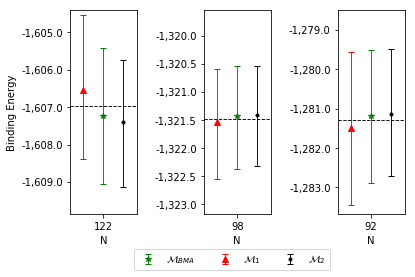

In [11]:
# Fig 4
nuclei = [0, 5, 3]
fig_n = 1
f = plt.figure(figsize=(6,3.75))

for i in nuclei:
    fi = plt.subplot(130 + fig_n)
    fi.get_yaxis().set_major_formatter(plt_base.ticker.FuncFormatter(lambda x, p: format(round(float(x),2), ',')))
    x = Z_N_test[[i],1]
    thickness_c = 1
    thickness_l = 0.9
    f1 = plt.errorbar(x, mbma[[i]], yerr=np.abs(np.array(mbmaerr)[:,[i]] - mbma[[i]]), fmt='*g', ecolor='g', capthick=thickness_c, elinewidth=thickness_l)
    f2 = plt.errorbar(x + 0.3, m1[[i]], yerr=np.abs(np.array(m1err)[:,[i]] - m1[[i]]), fmt='^r', ecolor='r', capthick=thickness_c, elinewidth=thickness_l)
    f3 = plt.errorbar(x - 0.3, m2[[i]], yerr=np.abs(np.array(m2err)[:,[i]] - m2[[i]]), fmt='.k', ecolor='black', capthick=thickness_c, elinewidth=thickness_l)
    plt.xlabel("N")
    if fig_n == 1:
        plt.ylabel('Binding Energy')
    plt.ylim(np.array(mbmaerr)[:,[i]][0] - 0.8,np.array(mbmaerr)[:,[i]][1] + 1)
    plt.plot([x + 0.5, x - 0.5], [data_test[[i]],data_test[[i]]], 'k-', linestyle = "--", color = "black", linewidth = thickness_l)
    plt.xlim((x + 0.5, x - 0.5))
    plt.xticks(x, x)
    fig_n = fig_n + 1 
plt.subplots_adjust(wspace = 1)
plt.legend((f1,f2,f3),(r'$\mathcal{M}_{BMA}$', r'$\mathcal{M}_{1}$', r'$\mathcal{M}_{2}$'),loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
            bbox_transform = plt.gcf().transFigure, ncol=3)
f.savefig('BE_test.pdf', bbox_inches='tight',dpi = 300)

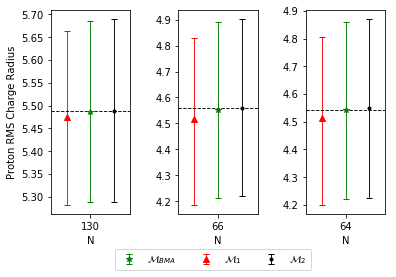

In [12]:
# Fig 5
nuclei = [10, 14, 13]
fig_n = 1
f = plt.figure(figsize=(6,3.75))
for i in nuclei:
    plt.subplot(130 + fig_n)
    x = Z_N_test[[i],1]
    thickness_c = 1
    thickness_l = 0.9
    f1 = plt.errorbar(x, mbma[[i]], yerr=np.abs(np.array(mbmaerr)[:,[i]] - mbma[[i]]), fmt='*g', ecolor='g', capthick=thickness_c, elinewidth=thickness_l)
    f2 = plt.errorbar(x + 0.3, m1[[i]], yerr=np.abs(np.array(m1err)[:,[i]] - m1[[i]]), fmt='^r', ecolor='r', capthick=thickness_c, elinewidth=thickness_l)
    f3 = plt.errorbar(x - 0.3, m2[[i]], yerr=np.abs(np.array(m2err)[:,[i]] - m2[[i]]), fmt='.k', ecolor='black', capthick=thickness_c, elinewidth=thickness_l)
    plt.xlabel("N")
    if fig_n == 1:
        plt.ylabel('Proton RMS Charge Radius')
    plt.plot([x + 0.5, x - 0.5], [data_test[[i]],data_test[[i]]], 'k-', linestyle = "--", color = "black", linewidth = thickness_l)
    plt.xlim((x + 0.5, x - 0.5))
    plt.xticks(x, x)
    fig_n = fig_n + 1
    
plt.subplots_adjust(wspace = 0.6)
plt.legend((f1,f2,f3),(r'$\mathcal{M}_{BMA}$', r'$\mathcal{M}_{1}$', r'$\mathcal{M}_{2}$'),loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
            bbox_transform = plt.gcf().transFigure, ncol=3)
f.savefig('RMS_test.pdf', bbox_inches='tight',dpi = 300)